# Metadata harmonization in the training dataset
This notebook loads, visualizes, and annotates multiple versions of the training dataset, focusing on standardizing key metadata columns for consistency.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

## Step 1: creating a unified broad annotation of the dataset `Velmeshev_Braun_Wang.h5ad`.

In [3]:
velm_braun_wang = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/Velmeshev_Braun_Wang.h5ad')

#### This image displays the identified clusters along with the automatic annotations assigned to them by the Cytograph pipeline.

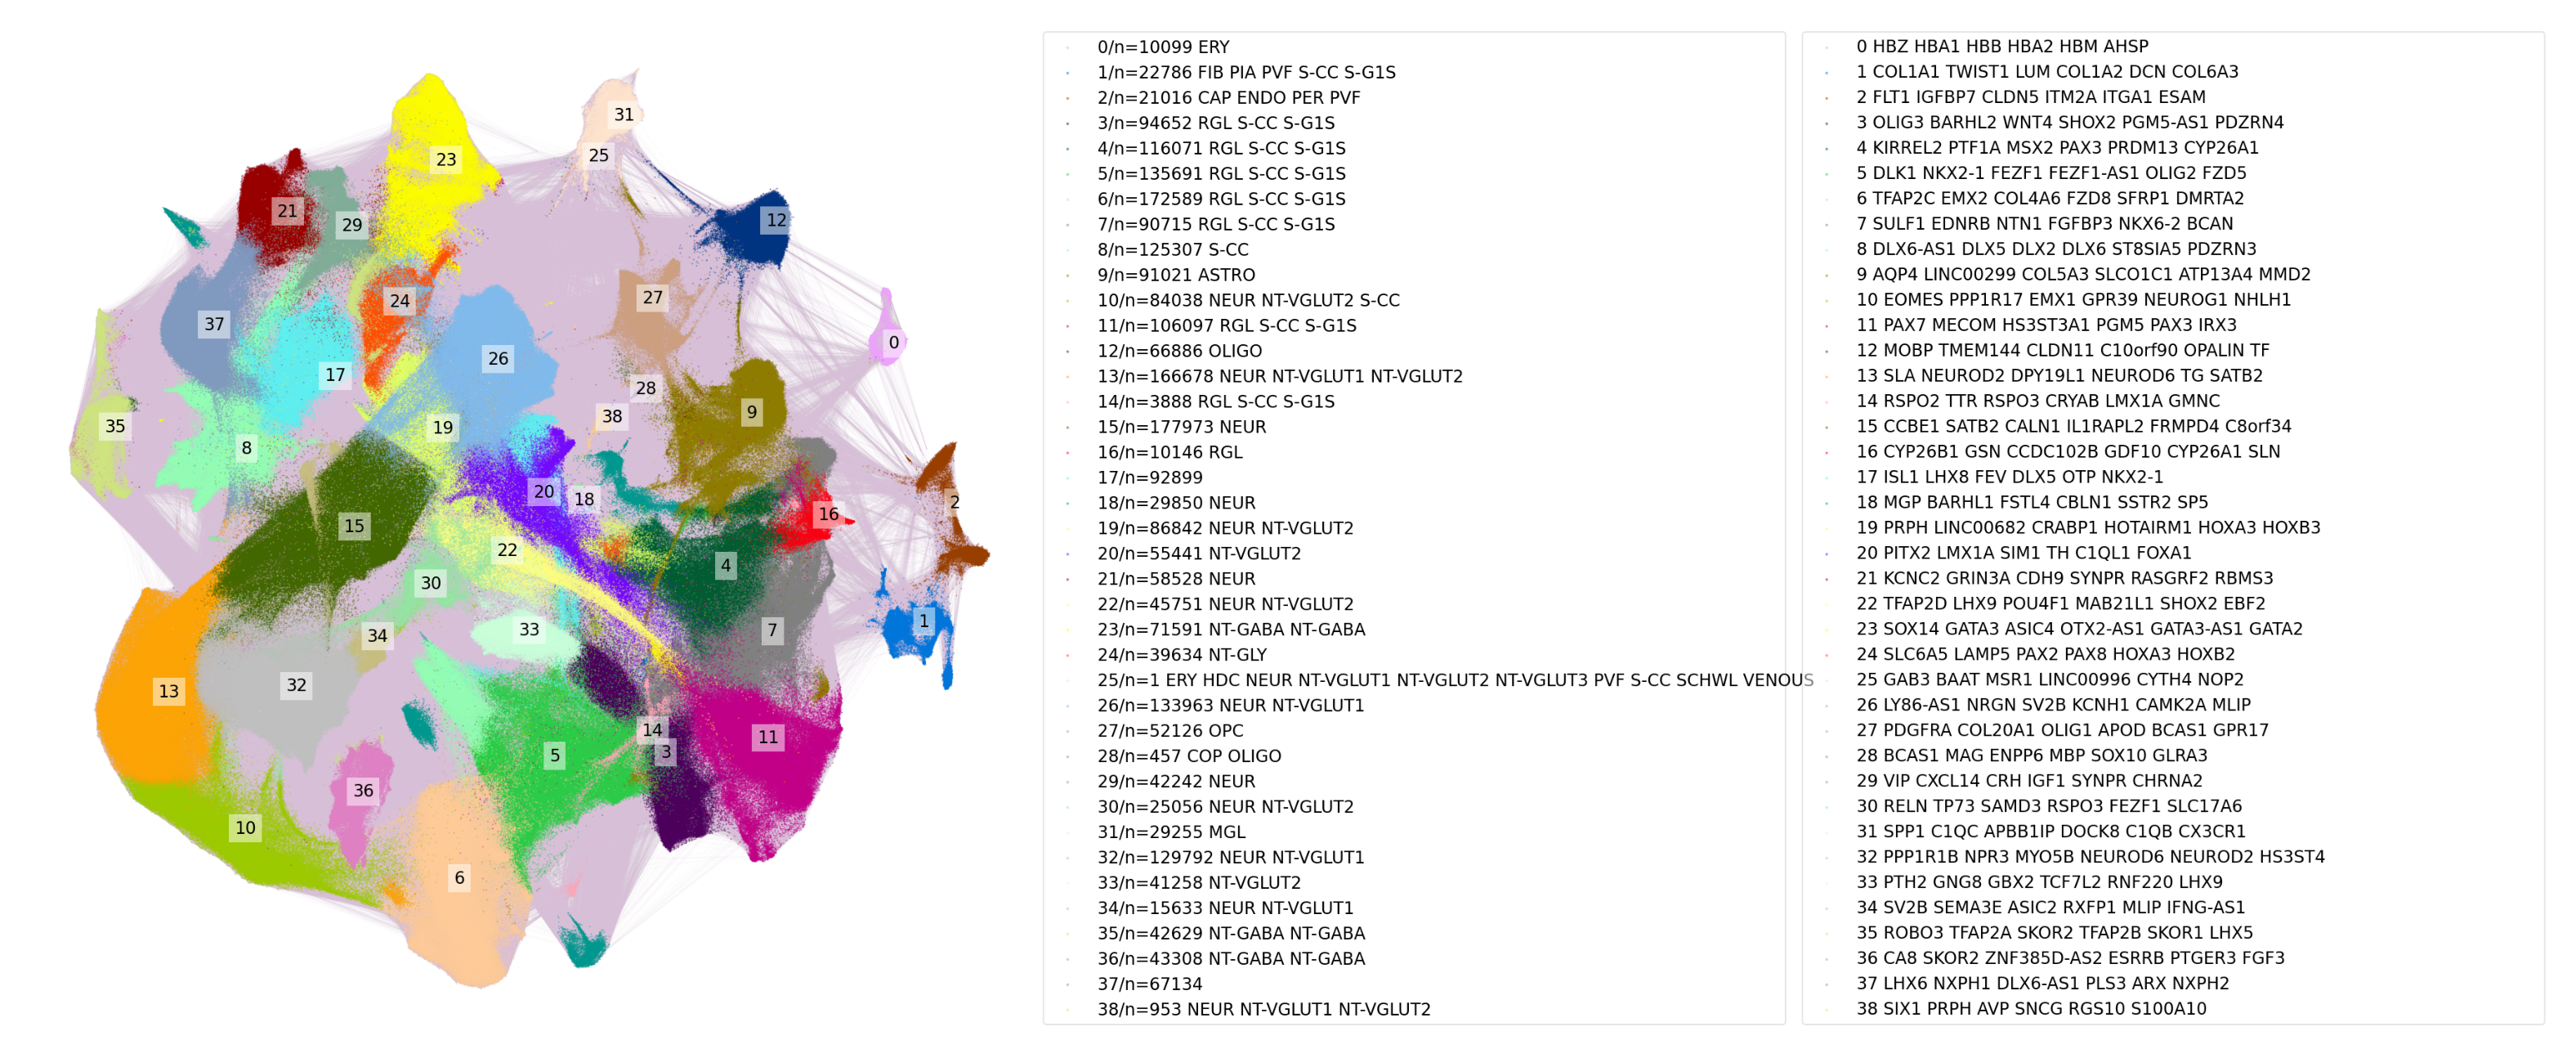

In [4]:
img = Image.open('/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/Velmeshev_Braun_Wang/manifold_UMAP.png')
plt.figure(figsize=(25, 25)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### This UMAPs display cell annotations from three distinct sources: 'cell_type' (Velm.), 'AnnotationAle' (Braun), and 'subclass' (Wang). The purpose is to compare these labels with the automatic annotation provided by Cytograph in the previous image, illustrating how they align or differ.

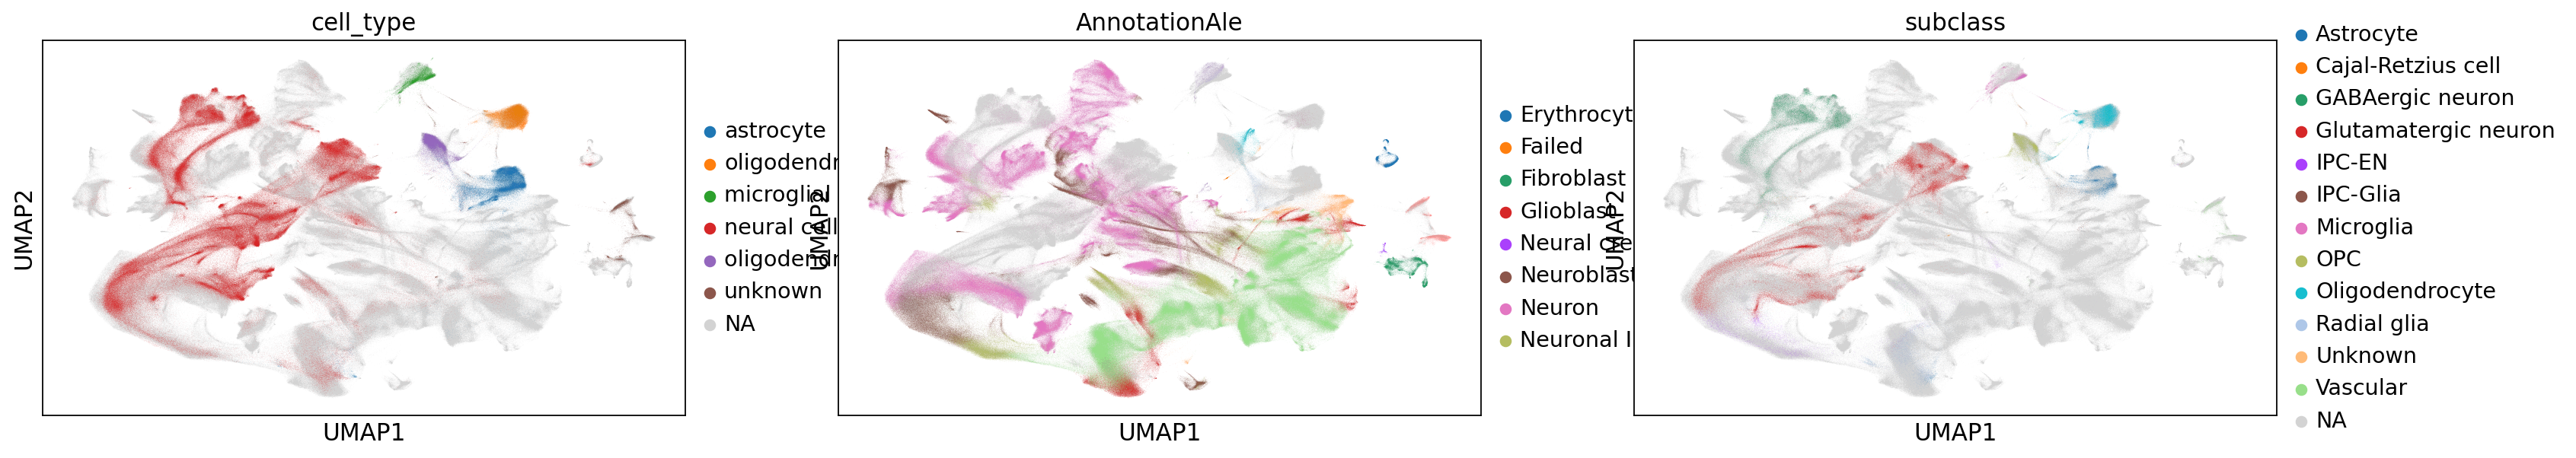

In [5]:
sc.pl.embedding(velm_braun_wang, basis = 'UMAP', color = ['cell_type', 'AnnotationAle', 'subclass'])

#### Creating a broad cell type dictionary for cluster mapping

Based on this comparison, I have created a dictionary to map clusters to their respective broad cell types. I opted for a general level of annotation since it sufficiently meets the requirements for generating images later on, which is the primary purpose of this mapping.

In [6]:
clusters = velm_braun_wang.obs['Clusters']
cluster_map = {
    0: 'erythrocytes',
    1: 'fibroblast',
    2: 'vascular',
    3: 'radial glia', 4: 'radial glia', 5: 'radial glia', 6: 'radial glia',
    7: 'radial glia', 9: 'astrocytes', 11: 'radial glia', 12: 'oligodendrocytes',
    14: 'radial glia', 16: 'radial glia', 25: 'microglia', 27: 'OPC',
    28: 'OPC', 31: 'microglia',
    8: 'neuronal cells', 10: 'neuronal cells', 13: 'neuronal cells', 15: 'neuronal cells',
    17: 'neuronal cells', 18: 'neuronal cells', 19: 'neuronal cells', 20: 'neuronal cells',
    21: 'neuronal cells', 22: 'neuronal cells', 23: 'neuronal cells', 24: 'neuronal cells',
    26: 'neuronal cells', 29: 'neuronal cells', 30: 'neuronal cells', 32: 'neuronal cells',
    33: 'neuronal cells', 34: 'neuronal cells', 35: 'neuronal cells', 36: 'neuronal cells',
    37: 'neuronal cells', 38: 'neuronal cells'
}

velm_braun_wang.obs['FinalBroadAnnotations'] = clusters.map(cluster_map)
velm_braun_wang.obs['FinalBroadAnnotations'].value_counts()

FinalBroadAnnotations
neuronal cells      1576500
radial glia          729849
astrocytes            91021
oligodendrocytes      66886
OPC                   52583
microglia             29256
fibroblast            22786
vascular              21016
erythrocytes          10099
Name: count, dtype: int64

#### I saved the result in the 'velm_braun_wang.h5ad' anndata object.

In [7]:
#velm_braun_wang.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/velm_braun_wang.h5ad')

## Step 2: adding a 'batch' column to the refined eveloping brain meta-atlas  This step allows us to distinguish between the three primary datasets in the meta-atlas. I will assign a 'batch' value to each cell based on its origin: cells labeled under 'cell_type' are from Velmeshev et al., those under 'AnnotationAle' are from Braun et al., and those under 'subclass' are from Wang et al..

In [8]:
adata = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')

In [9]:
adata.obs['ThirdManualAnnotations'].value_counts()

ThirdManualAnnotations
nIPCs                64827
early Radial Glia    54535
late Radial Glia     39861
Astrocytes           38105
Subcortical nIPCs    24285
OPCs                 20927
pre-Astrocytes        3673
pre-OPCs              2227
Name: count, dtype: int64

In [10]:
def update_obs_column(adata):

        adata.obs['batch'] = None
        adata.obs.loc[adata.obs['CellClass'].notna(), 'batch'] = 'Braun'
        adata.obs.loc[adata.obs['subclass'].notna(), 'batch'] = 'Wang'
        adata.obs.loc[adata.obs['cell_type'].notna(), 'batch'] = 'Velmeshev'
        return adata

adata = update_obs_column(adata)


In [11]:
adata.obs.batch.value_counts().sum()

248440

## Step 3: harmonizing developmental stage nomenclature

#### I appreciate the way Velmeshev et al. categorized developmental stages and have decided to align the terminology used by Braun et al. and Wang et al. with their definitions for consistency.
the labels for the stage of development are:

'development_stage' for Velmeshev et al.,

'development_stage_ontology_term_id' for Braun et al., 

'Estimated_postconceptional_age_in_days' for Wang et al.

In [12]:
adata.obs.development_stage.value_counts()

development_stage
fifth LMP month human stage      29551
ninth LMP month human stage      10546
eighth LMP month human stage      6441
5-month-old human stage           5413
1-month-old human stage           4004
fourth LMP month human stage      3885
newborn human stage               3235
3-month-old human stage           3158
seventh LMP month human stage     2885
2-month-old human stage           1968
sixth LMP month human stage       1706
4-month-old human stage            737
Name: count, dtype: int64

#### Braun
I defined a mapping dictionary to convert developmental stage IDs of Braun et al. into human-readable stage names, then applied it to create a new column in the dataset.

In [13]:
stage_braun_mapping = {
    'HsapDv:0000099': 'five LMP weeks human stage',
    'HsapDv:0000100': 'six LMP weeks human stage',
    'HsapDv:0000101': 'seven LMP weeks human stage',
    'HsapDv:0000102': 'eight LMP weeks human stage',
    'HsapDv:0000103': 'nine LMP weeks human stage',
    'HsapDv:0000104': 'ten LMP weeks human stage',
    'HsapDv:0000105': 'eleven LMP weeks human stage',
    'HsapDv:0000106': 'twelve LMP weeks human stage',
    'HsapDv:0000107': 'thirteen LMP weeks human stage',
    'HsapDv:0000108': 'fourteen LMP weeks human stage',
    'HsapDv:0000198': 'fourth LMP month human stage',
    'HsapDv:0000199': 'fifth LMP month human stage',
    'HsapDv:0000200': 'sixth LMP month human stage',
    'HsapDv:0000201': 'seventh LMP month human stage',
    'HsapDv:0000202': 'eighth LMP month human stage',
    'HsapDv:0000203': 'ninth LMP month human stage',
    'HsapDv:0000082': 'newborn human stage',
    'HsapDv:0000174': '1-month-old human stage',
    'HsapDv:0000175': '2-month-old human stage',
    'HsapDv:0000176': '3-month-old human stage',
    'HsapDv:0000177': '4-month-old human stage',
    'HsapDv:0000178': '5-month-old human stage'
}

adata.obs['braun_final_developmental_stage'] = adata.obs['development_stage_ontology_term_id'].map(stage_braun_mapping)
adata[adata.obs.batch == 'Braun'].obs[['development_stage_ontology_term_id', 'braun_final_developmental_stage']].head()

development_stage_ontology_term_id  \
10X92_3:AAACGGGCACCTTGTC                     HsapDv:0000103   
10X92_3:AAAGCAACACATGTGT                     HsapDv:0000103   
10X92_3:AAGGTTCGTACCGTTA                     HsapDv:0000103   
10X92_3:AATCGGTGTTCGTCTC                     HsapDv:0000103   
10X92_3:ACACCCTTCTCGTTTA                     HsapDv:0000103   

                         braun_final_developmental_stage  
10X92_3:AAACGGGCACCTTGTC      nine LMP weeks human stage  
10X92_3:AAAGCAACACATGTGT      nine LMP weeks human stage  
10X92_3:AAGGTTCGTACCGTTA      nine LMP weeks human stage  
10X92_3:AATCGGTGTTCGTCTC      nine LMP weeks human stage  
10X92_3:ACACCCTTCTCGTTTA      nine LMP weeks human stage

#### Wang
I did the same for the Wang et al. variable 'Estimated_postconceptional_age_in_days'.

In [14]:
stage_wang_mapping = {
    54.0: 'eight LMP weeks human stage',
    60.0: 'ninth LMP weeks human stage',
    63.0: 'ninth LMP weeks human stage',
    77.0: 'eleven LMP weeks human stage',
    84.0: 'twelve LMP weeks human stage',
    91.0: 'thirteen LMP weeks human stage',
    98.0: 'fourteen LMP weeks human stage',
    112.0: 'fourth LMP month human stage',
    126.0: 'fourth LMP month human stage',
    147.0: 'fifth LMP month human stage',
    178.0: 'sixth LMP month human stage',
    224.0: 'seventh LMP month human stage',
    226.0: 'seventh LMP month human stage',
    239.0: 'eighth LMP month human stage',
    246.0: 'eighth LMP month human stage',
    373.0: '3-month-old human stage',
    455.0: '5-month-old human stage',
    498.0: '6-month-old human stage',
    507.0: '7-month-old human stage',
    574.0: '8-month-old human stage'
}

adata.obs['wang_final_developmental_stage'] = adata.obs['Estimated_postconceptional_age_in_days'].map(stage_wang_mapping)
adata[adata.obs.batch == 'Wang'].obs[['Estimated_postconceptional_age_in_days', 'wang_final_developmental_stage']].head()

Estimated_postconceptional_age_in_days  \
ARKFrozen-18-PFC_AAACAGCCAGGTTCAC-1                                    98.0   
ARKFrozen-18-PFC_AAAGCAAGTGCAACTA-1                                    98.0   
ARKFrozen-18-PFC_AAAGCCCGTCAATGTG-1                                    98.0   
ARKFrozen-18-PFC_AAAGCCGCACTTAACG-1                                    98.0   
ARKFrozen-18-PFC_AAAGGAGCATTGTTGG-1                                    98.0   

                                     wang_final_developmental_stage  
ARKFrozen-18-PFC_AAACAGCCAGGTTCAC-1  fourteen LMP weeks human stage  
ARKFrozen-18-PFC_AAAGCAAGTGCAACTA-1  fourteen LMP weeks human stage  
ARKFrozen-18-PFC_AAAGCCCGTCAATGTG-1  fourteen LMP weeks human stage  
ARKFrozen-18-PFC_AAAGCCGCACTTAACG-1  fourteen LMP weeks human stage  
ARKFrozen-18-PFC_AAAGGAGCATTGTTGG-1  fourteen LMP weeks human stage

#### Let's merge all of them into a single column.

In [15]:
def combine_stages(row):
    stages = set()
    for col in ['development_stage', 
                'wang_final_developmental_stage', 
                'braun_final_developmental_stage']:
        val = row[col]
        if pd.notnull(val):
            stages.add(val)
    return "; ".join(stages)

adata.obs['final_developmental_stage'] = adata.obs.apply(combine_stages, axis=1)
print(adata.obs.final_developmental_stage.value_counts())
print(adata.obs.final_developmental_stage.value_counts().sum())

final_developmental_stage
fifth LMP month human stage       30325
eight LMP weeks human stage       26856
ten LMP weeks human stage         23843
six LMP weeks human stage         20440
eleven LMP weeks human stage      19517
twelve LMP weeks human stage      17607
nine LMP weeks human stage        15853
ninth LMP month human stage       10546
5-month-old human stage            9127
eighth LMP month human stage       9015
ninth LMP weeks human stage        8966
thirteen LMP weeks human stage     8741
fourteen LMP weeks human stage     8183
fourth LMP month human stage       6967
3-month-old human stage            4828
seven LMP weeks human stage        4125
1-month-old human stage            4004
seventh LMP month human stage      4003
newborn human stage                3235
8-month-old human stage            3210
2-month-old human stage            1968
sixth LMP month human stage        1935
7-month-old human stage            1931
6-month-old human stage            1336
five LMP weeks

#### I have updated the previously imported Anndata object by incorporating the new information.

In [16]:
#adata.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')